In [27]:
# Jupyter-only argpatch: avoid argparse conflicts and inject minimal args
import sys
from types import SimpleNamespace

# Prevent Jupyter kernel args (e.g., --f=...) from reaching argparse
sys.argv = [sys.argv[0]]

# Option B: monkeypatch get_arguments so any import uses our minimal args
try:
    import oai_agents.common.arguments as _argsmod
    _argsmod.get_arguments = lambda: SimpleNamespace(
        layout_names=["3_chefs_smartfactory"],
        horizon=50,
        num_players=3,
        encoding_fn="OAI_lossless",
        device="cuda",
        num_stack=1,
        reward_magnifier=1.0,
        dynamic_reward=True,
        final_sparse_r_ratio=0.1,
        overcooked_verbose=False,
        n_envs=1,
        shape_reward=True
    )
    print("✅ Injected notebook-local get_arguments()");
except Exception as e:
    print("ℹ️ Skipped get_arguments monkeypatch:", e)


✅ Injected notebook-local get_arguments()


In [28]:
# Setup: imports and environment creation
import os, sys, time
from pprint import pprint

# Ensure project is on path
project_root = os.path.abspath(os.path.join(os.getcwd()))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from pymarlzooplus.envs import REGISTRY

layout_name = "3_chefs_smartfactory"
num_agents = 3
horizon = 400

# Create environment
env_fn = REGISTRY["multi_overcooked"]
env = env_fn(layout_name=layout_name, num_agents=num_agents, horizon=horizon, reward_type="sparse")

print("Env created.")
print("Env info:")
pprint(env.get_env_info())


✅ Multi Overcooked (core) initialized: 3_chefs_smartfactory, 3 agents
Env created.
Env info:
{'episode_limit': 400,
 'n_actions': 6,
 'n_agents': 3,
 'obs_shape': np.int64(810),
 'state_shape': 100}


In [29]:
# 1) Introspect wrapper and base env attributes/methods
print("Wrapper (MultiAgentEnv) attributes/methods:\n")
wrapper_attrs = sorted([a for a in dir(env) if not a.startswith("__")])
print(wrapper_attrs)

# Try to access base env (OvercookedGymEnv)
base_env = getattr(env, 'env', None)
print("\nHas base env:", base_env is not None)
if base_env:
    print("\nBase env (OvercookedGymEnv) attributes/methods:\n")
    base_attrs = sorted([a for a in dir(base_env) if not a.startswith("__")])
    print(base_attrs)


Wrapper (MultiAgentEnv) attributes/methods:

['_done', '_extract_observations', '_extract_state', '_info', '_init_core_env', '_init_fallback_environment', '_obs', '_setup_spaces', '_state', 'close', 'encoding_scheme', 'env', 'episode_limit', 'get_avail_actions', 'get_avail_agent_actions', 'get_env_info', 'get_obs', 'get_obs_agent', 'get_obs_size', 'get_state', 'get_state_size', 'get_stats', 'get_total_actions', 'horizon', 'layout_name', 'n_actions', 'n_agents', 'num_agents', 'obs_shape', 'render', 'render_enabled', 'reset', 'reward_type', 'save_replay', 'seed', 'step']

Has base env: True

Base env (OvercookedGymEnv) attributes/methods:

['action_masks', 'action_space', 'args', 'close', 'completed_tasks', 'deterministic', 'device', 'dynamic_reward', 'encoding_fn', 'env', 'env_idx', 'final_sparse_r_ratio', 'get_joint_action', 'get_layout_name', 'get_obs', 'get_teammate_from_idx', 'grid_shape', 'is_eval_env', 'joint_action', 'layout_name', 'learner', 'main_agent_stack_frames', 'mdp', 'me

In [30]:
# 2) Reset and inspect observations/state/reward/info
obs_list, state = env.reset()
print("Reset done.")
print("Obs count:", len(obs_list))
print("Obs[0] keys/shapes:")
try:
    sample_obs = obs_list[0]
    if isinstance(sample_obs, dict):
        for k, v in sample_obs.items():
            shape = getattr(v, 'shape', None)
            print(f"  - {k}: {type(v).__name__}, shape={shape}")
    else:
        print(type(sample_obs), getattr(sample_obs, 'shape', None))
except Exception as e:
    print("Obs[0] inspection error:", e)

print("\nState shape:", getattr(state, 'shape', None))


Reset done.
Obs count: 3
Obs[0] keys/shapes:
<class 'numpy.ndarray'> (27, 6, 5)

State shape: (100,)


In [31]:
# 3) Actions and OvercookedState structure
from pymarlzooplus.envs.overcooked_ai.src.overcooked_ai_py.mdp.overcooked_mdp import Action

print("Total actions:", env.get_total_actions())
print("Action indices -> symbols:")
for i in range(env.get_total_actions()):
    a = Action.INDEX_TO_ACTION[i]
    print(i, "->", a)

# Inspect OvercookedState from base env
base_env = getattr(env, 'env', None)
if base_env is not None:
    state = base_env.state
    print("\nOvercookedState fields:", [k for k in dir(state) if not k.startswith("__") and not callable(getattr(state, k))])
    print("Players:", state.players)
    print("Objects:", getattr(state, 'objects', None))


Total actions: 6
Action indices -> symbols:
0 -> (0, -1)
1 -> (0, 1)
2 -> (1, 0)
3 -> (-1, 0)
4 -> (0, 0)
5 -> interact

OvercookedState fields: ['_all_orders', '_bonus_orders', 'all_objects_by_type', 'all_objects_list', 'all_orders', 'bonus_orders', 'objects', 'player_objects_by_type', 'player_orientations', 'player_positions', 'players', 'players_pos_and_or', 'timestep', 'unowned_objects_by_type']
Players: ((3, 1) facing (0, -1) holding None, (1, 2) facing (0, -1) holding None, (3, 3) facing (0, -1) holding None)
Objects: {}


In [32]:
# 4) Step loop with rendering
import numpy as np

obs_list, state = env.reset()

for t in range(10):
    actions = [np.random.randint(0, env.get_total_actions()) for _ in range(num_agents)]
    reward, done, info = env.step(actions)
    print(f"t={t}, reward={reward:.3f}, done={done}")
    env.render()
    if done:
        break

env.close()
print("Done.")


t=0, reward=0.000, done=False
t=1, reward=0.000, done=False
t=2, reward=0.000, done=False
t=3, reward=0.000, done=False
t=4, reward=0.000, done=False
t=5, reward=0.000, done=False
t=6, reward=0.000, done=False
t=7, reward=0.000, done=False
t=8, reward=0.000, done=False
t=9, reward=0.000, done=False
Done.


In [33]:
# 4b) Step loop with actions list and players' pose (position & orientation)
import numpy as np
from pymarlzooplus.envs.overcooked_ai.src.overcooked_ai_py.mdp.overcooked_mdp import Action

obs_list, state = env.reset()

# Print action list once
action_list = [Action.INDEX_TO_ACTION[i] for i in range(env.get_total_actions())]
print("Actions (index->symbol):", [(i, action_list[i]) for i in range(len(action_list))])

base_env = getattr(env, 'env', None)

for t in range(10):
    actions = [np.random.randint(0, env.get_total_actions()) for _ in range(num_agents)]
    symbols = [Action.INDEX_TO_ACTION[a] for a in actions]
    reward, done, info = env.step(actions)

    print(f"t={t}, reward={reward:.3f}, done={done}")
    print("  actions idx:", actions)
    print("  actions sym:", symbols)

    # Dump players' position and orientation
    if base_env is not None and hasattr(base_env, 'state'):
        st = base_env.state
        poses = []
        for i, p in enumerate(st.players):
            pos = getattr(p, 'position', None)
            ori = getattr(p, 'orientation', None)
            poses.append((i, pos, str(ori)))
        print("  players (idx, pos, orient):", poses)

    # Optional render
    # env.render()
    if done:
        break

print("Pose dump done.")


Actions (index->symbol): [(0, (0, -1)), (1, (0, 1)), (2, (1, 0)), (3, (-1, 0)), (4, (0, 0)), (5, 'interact')]
t=0, reward=0.000, done=False
  actions idx: [4, 0, 3]
  actions sym: [(0, 0), (0, -1), (-1, 0)]
  players (idx, pos, orient): [(0, (3, 1), '(0, -1)'), (1, (1, 1), '(0, -1)'), (2, (3, 3), '(-1, 0)')]
t=1, reward=0.000, done=False
  actions idx: [5, 4, 3]
  actions sym: ['interact', (0, 0), (-1, 0)]
  players (idx, pos, orient): [(0, (3, 1), '(0, -1)'), (1, (1, 1), '(0, -1)'), (2, (3, 3), '(-1, 0)')]
t=2, reward=0.000, done=False
  actions idx: [5, 4, 2]
  actions sym: ['interact', (0, 0), (1, 0)]
  players (idx, pos, orient): [(0, (3, 1), '(0, -1)'), (1, (1, 1), '(0, -1)'), (2, (4, 3), '(1, 0)')]
t=3, reward=0.000, done=False
  actions idx: [3, 0, 1]
  actions sym: [(-1, 0), (0, -1), (0, 1)]
  players (idx, pos, orient): [(0, (3, 1), '(-1, 0)'), (1, (1, 1), '(0, -1)'), (2, (4, 3), '(0, 1)')]
t=4, reward=0.000, done=False
  actions idx: [5, 0, 2]
  actions sym: ['interact', (0, 

In [34]:
# 4c) Inspect info dict structure from a single step
from pprint import pprint
import numpy as np

obs_list, state = env.reset()
# Take a deterministic simple action (all NOOP) to make info stable
try:
    from pymarlzooplus.envs.overcooked_ai.src.overcooked_ai_py.mdp.overcooked_mdp import Action
    noop_idx = 4  # (0,0) usually NOOP
    actions = [noop_idx for _ in range(num_agents)]
except Exception:
    actions = [0 for _ in range(num_agents)]

reward, done, info = env.step(actions)

print("Reward:", reward, " Done:", done)
print("\nInfo keys ({}):".format(len(info)))
print(list(info.keys()))

# Show types for each key
print("\nInfo key -> type:")
for k, v in info.items():
    t = type(v).__name__
    shape = getattr(v, 'shape', None)
    print(f"  {k}: {t} shape={shape}")

print("\nFull info (truncated if large):")
pprint(info)


Reward: 0.0  Done: False

Info keys (5):
['agent_infos', 'sparse_r_by_agent', 'shaped_r_by_agent', 'phi_s', 'phi_s_prime']

Info key -> type:
  agent_infos: list shape=None
  sparse_r_by_agent: list shape=None
  shaped_r_by_agent: list shape=None
  phi_s: NoneType shape=None
  phi_s_prime: NoneType shape=None

Full info (truncated if large):
{'agent_infos': [{}, {}, {}],
 'phi_s': None,
 'phi_s_prime': None,
 'shaped_r_by_agent': [0, 0, 0],
 'sparse_r_by_agent': [0, 0, 0]}


In [35]:
# 5) Inspect wrapper state vector and underlying OvercookedState structure
from pprint import pprint

# Wrapper state (flattened vector used by algorithms)
obs_list, state_vec = env.reset()
print("Wrapper get_state():")
print("  type:", type(state_vec).__name__)
print("  shape:", getattr(state_vec, 'shape', None))
print("  sample (first 20):", state_vec[:20] if hasattr(state_vec, '__len__') else state_vec)

# Underlying OvercookedState (rich object)
base_env = getattr(env, 'env', None)
if base_env is not None and hasattr(base_env, 'state'):
    s = base_env.state
    print("\nUnderlying OvercookedState object:")
    print("  class:", s.__class__.__name__)
    # Try to access to_dict for a structured view
    if hasattr(s, 'to_dict') and callable(getattr(s, 'to_dict')):
        sdict = s.to_dict()
        print("  to_dict keys ({}):".format(len(sdict)))
        print(list(sdict.keys()))
        print("\n  Key -> type/shape:")
        for k, v in sdict.items():
            t = type(v).__name__
            shape = getattr(v, 'shape', None)
            print(f"    {k}: {t} shape={shape}")
        # Show a few commonly useful entries
        for k in ["player_positions", "player_orientations", "timestep"]:
            if k in sdict:
                print(f"\n  {k}:")
                pprint(sdict[k])
    else:
        print("  No to_dict() available. Raw attributes:")
        fields = [k for k in dir(s) if not k.startswith("__") and not callable(getattr(s, k))]
        print("  fields:", fields)
        # Print a few known ones if present
        for name in ["players", "player_positions", "player_orientations", "timestep"]:
            if hasattr(s, name):
                print(f"  {name}:", getattr(s, name))

# MDP/layout context
if base_env is not None and hasattr(base_env, 'mdp'):
    mdp = base_env.mdp
    print("\nMDP context:")
    print("  layout:", getattr(mdp, 'layout_name', None))
    terrain = getattr(mdp, 'terrain_mtx', None)
    if terrain is not None:
        print("  terrain shape:", (len(terrain), len(terrain[0]) if len(terrain)>0 else 0))
        # print a small slice
        preview_rows = min(3, len(terrain))
        print("  terrain preview (first", preview_rows, "rows):")
        for r in range(preview_rows):
            print("   ", ''.join(terrain[r]))


Wrapper get_state():
  type: ndarray
  shape: (100,)
  sample (first 20): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Underlying OvercookedState object:
  class: OvercookedState
  to_dict keys (5):
['players', 'objects', 'bonus_orders', 'all_orders', 'timestep']

  Key -> type/shape:
    players: list shape=None
    objects: list shape=None
    bonus_orders: list shape=None
    all_orders: list shape=None
    timestep: int shape=None

  timestep:
0

MDP context:
  layout: 3_chefs_smartfactory
  terrain shape: (5, 6)
  terrain preview (first 3 rows):
    XXXPXX
    O X  P
    O X  X


In [36]:
# 6) Compare multiple encoding schemes (MDP/env and custom encoders)
import numpy as np
from pprint import pprint

# Access raw state and mdp/env
base_env = getattr(env, 'env', None)
assert base_env is not None, "Base env not found"
raw_state = base_env.state
mdp = base_env.mdp
oc_env = base_env.env  # OvercookedEnv

# 6.1) MDP lossless_state_encoding (robust to tuple output)
try:
    enc_out = mdp.lossless_state_encoding(raw_state)
    enc_arr = enc_out[0] if isinstance(enc_out, tuple) else enc_out
    enc_arr = np.asarray(enc_arr)
    print("lossless_state_encoding shape:", enc_arr.shape)
except Exception as e:
    print("lossless_state_encoding error:", e)

# 6.2) OvercookedEnv.featurize_state_mdp
try:
    feat = oc_env.featurize_state_mdp(raw_state)
    print("\nfeaturize_state_mdp type:", type(feat).__name__)
    if isinstance(feat, dict):
        print("featurize_state_mdp keys:", list(feat.keys()))
        # common structure: both_agent_obs, other_agent_env_idx
        for k, v in feat.items():
            print(f"  {k}: type={type(v).__name__}, shape={getattr(v, 'shape', None)}")
    else:
        print("featurize_state_mdp value:", feat)
except Exception as e:
    print("featurize_state_mdp error:", e)

# 6.3) Custom encoders from ENCODING_SCHEMES (oai_agents)
try:
    from oai_agents.common.state_encodings import ENCODING_SCHEMES
    grid_shape = getattr(base_env, 'grid_shape', (7,7))
    horizon = getattr(env, 'horizon', 400)
    for enc_name in ["OAI_lossless", "OAI_feats"]:
        if enc_name in ENCODING_SCHEMES:
            enc_fn = ENCODING_SCHEMES[enc_name]
            obs = enc_fn(mdp, raw_state, grid_shape, horizon, p_idx=0)
            print(f"\nENCODING_SCHEME: {enc_name}")
            if isinstance(obs, dict):
                for k, v in obs.items():
                    print(f"  {k}: type={type(v).__name__}, shape={getattr(v, 'shape', None)}")
            else:
                print("  raw type:", type(obs).__name__, "shape:", getattr(obs, 'shape', None))
        else:
            print(f"\nENCODING_SCHEME: {enc_name} not available")
except Exception as e:
    print("ENCODING_SCHEMES error:", e)


lossless_state_encoding shape: (6, 5, 27)
Computing MediumLevelActionManager
medium level action manager with different params or mdp found, computing from scratch
Computing MediumLevelActionManager to be saved in /home/juliecandoit98/overcooked_ai/src/overcooked_ai_py/data/planners/3_chefs_smartfactory_am.pkl
It took 0.07592487335205078 seconds to create mlam

featurize_state_mdp type: list
featurize_state_mdp value: [array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  1.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., -1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  2.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., -1.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
 

In [37]:
s = env.env.state
print("players ->", s.players)
print("positions ->", getattr(s, "player_positions", "N/A"))
print("orientations ->", getattr(s, "player_orientations", "N/A"))
print("players_pos_and_or ->", getattr(s, "players_pos_and_or", "N/A"))
print("objects ->", s.objects)
mdp = env.env.mdp
try:
    enc_out = mdp.lossless_state_encoding(s)
    enc_arr = enc_out[0] if isinstance(enc_out, tuple) else enc_out
    enc_arr = np.asarray(enc_arr)
    print(enc_arr.shape)
except Exception as e:
    print("lossless encoding error:", e)

players -> ((3, 1) facing (0, -1) holding None, (1, 2) facing (0, -1) holding None, (3, 3) facing (0, -1) holding None)
positions -> ((3, 1), (1, 2), (3, 3))
orientations -> ((0, -1), (0, -1), (0, -1))
players_pos_and_or -> (((3, 1), (0, -1)), ((1, 2), (0, -1)), ((3, 3), (0, -1)))
objects -> {}
(6, 5, 27)


In [38]:
# 7) Headless inline rendering utilities for Overcooked (Jupyter)
import os
# Use dummy drivers to avoid opening a real window/audio in Jupyter
os.environ.setdefault("SDL_VIDEODRIVER", "dummy")
os.environ.setdefault("SDL_AUDIODRIVER", "dummy")
os.environ.setdefault("PYGAME_HIDE_SUPPORT_PROMPT", "1")

import numpy as np
import pygame
from typing import Optional

# Import StateVisualizer (robust to different package paths)
from overcooked_ai_py.visualization.state_visualizer import StateVisualizer

# Ensure pygame is initialized for surfarray conversions
if not pygame.get_init():
    pygame.init()


def get_overcooked_frame(wrapper_env, tile_size: int = 32) -> Optional[np.ndarray]:
    """Return an RGB frame (H,W,3) of the current Overcooked state for inline display.
    Works with the multi-overcooked wrapper by reaching into its base OvercookedGymEnv.
    """
    base_env = getattr(wrapper_env, 'env', None) or wrapper_env  # OvercookedGymEnv or compatible
    if base_env is None or not hasattr(base_env, 'state'):
        return None

    # Determine terrain grid source
    grid = None
    try:
        # OvercookedGymEnv.env is OvercookedEnv, which has mdp
        grid = base_env.env.mdp.terrain_mtx
    except Exception:
        try:
            grid = base_env.mdp.terrain_mtx
        except Exception:
            grid = None

    surf = StateVisualizer(tile_size=tile_size).render_state(state=base_env.state, grid=grid)

    # Convert pygame surface (W,H,3) to (H,W,3) uint8
    arr = pygame.surfarray.array3d(surf)
    # Rotate to get (H, W, 3) correctly oriented
    frame = np.flip(np.rot90(arr, 3), 1).copy()
    return frame

print("✅ Inline rendering helpers ready (get_overcooked_frame)")


✅ Inline rendering helpers ready (get_overcooked_frame)


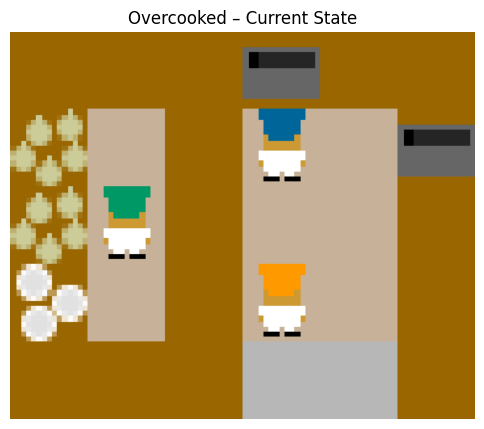

In [39]:
# 8) Show a single frame inline
import matplotlib.pyplot as plt

# Ensure env exists; if not, create quickly
try:
    env
except NameError:
    from pymarlzooplus.envs import REGISTRY
    env = REGISTRY["multi_overcooked"](layout_name="3_chefs_smartfactory", num_agents=3, horizon=200)
    env.reset()

frame = get_overcooked_frame(env, tile_size=48)
assert frame is not None, "Frame capture returned None"

plt.figure(figsize=(6,6))
plt.imshow(frame)
plt.axis('off')
plt.title('Overcooked – Current State')
plt.show()


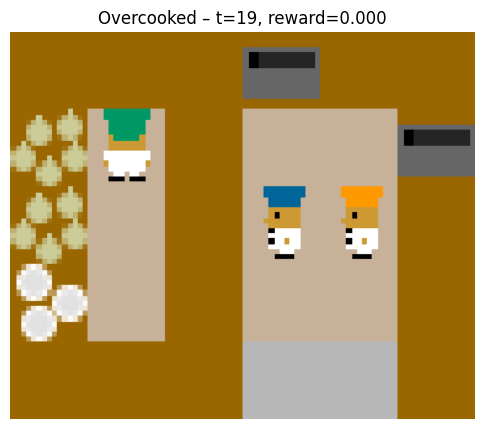

Collected 20 frames.


In [26]:
# 9) Short animated rollout rendered inline
import numpy as np
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import time

# Reset environment
env.reset()

frames = []
T = 20
for t in range(T):
    actions = [np.random.randint(0, env.get_total_actions()) for _ in range(env.n_agents)]
    reward, done, info = env.step(actions)
    frame = get_overcooked_frame(env, tile_size=48)
    if frame is not None:
        frames.append(frame)
        clear_output(wait=True)
        plt.figure(figsize=(6,6))
        plt.imshow(frame)
        plt.axis('off')
        plt.title(f'Overcooked – t={t}, reward={reward:.3f}')
        display(plt.gcf())
        plt.close()
    if done:
        break
    time.sleep(0.1)

print(f"Collected {len(frames)} frames.")
